In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from Utils.preprocessing import EcgDataset, ToTensor


transform = transforms.Compose([
    ToTensor(),
    transforms.Resize([64, 64])
    # transforms.Normalize(mean=[0.5], std=[0.5])
])

dataset = EcgDataset(
    root_dir="Data/training_data/dataset",
    transform=transform
)

train_data, val_data = random_split(dataset, [0.8,0.2])

train_loader = DataLoader(
    train_data,
    batch_size=64,
    shuffle=True
)
val_loader = DataLoader(
    val_data,
    batch_size=64,
    shuffle=True
)

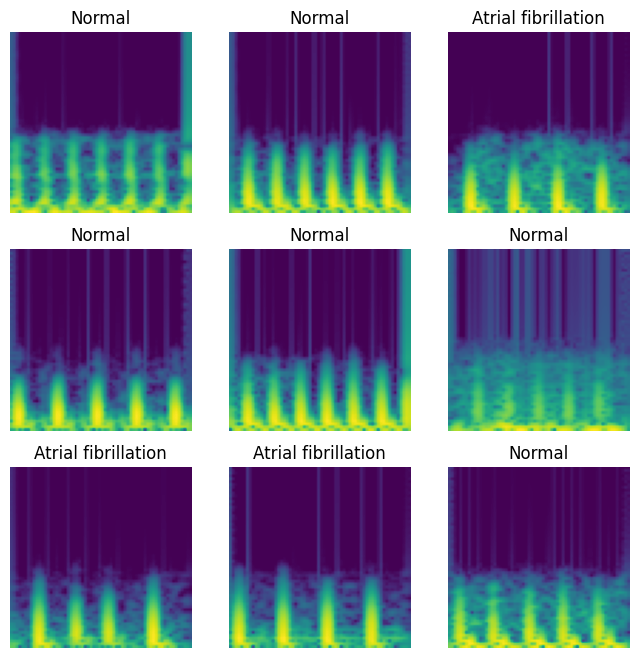

In [3]:
labels_map = {
    0: "Normal",
    1: "Atrial fibrillation"
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    # print(sample_idx)
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="viridis")
plt.show()

In [4]:
from torchsummary import summary
from Network.afib_detector_v1_0 import AfibDetector

net = AfibDetector()

if torch.cuda.is_available():
    net.cuda()

summary(net, (1,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 60, 60]             416
              ReLU-2           [-1, 16, 60, 60]               0
         MaxPool2d-3           [-1, 16, 30, 30]               0
            Conv2d-4           [-1, 32, 28, 28]           4,640
              ReLU-5           [-1, 32, 28, 28]               0
         MaxPool2d-6           [-1, 32, 14, 14]               0
            Conv2d-7           [-1, 64, 12, 12]          18,496
              ReLU-8           [-1, 64, 12, 12]               0
         MaxPool2d-9             [-1, 64, 6, 6]               0
          Dropout-10                 [-1, 2304]               0
           Linear-11                   [-1, 64]         147,520
             ReLU-12                   [-1, 64]               0
           Linear-13                    [-1, 2]             130
          Softmax-14                   

In [5]:
import torch.nn as nn
from torch import optim
from Utils.model_trainer import ModelTrainer
import os

MODEL_PATH = "./Models/experiments/afib_detector_v1_1_0"
if not os.path.exists(os.path.dirname(MODEL_PATH)):
        os.makedirs(os.path.dirname(MODEL_PATH))

learning_rate = 0.01

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

epochs = 5
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

net.to(device)

modelTrainer = ModelTrainer(MODEL_PATH)

modelTrainer.train_model(
    net,
    train_loader,
    val_loader,
    loss_fn,
    optimizer,
    device,
    epochs
)

Device: cuda:0
EPOCH 1:
	batch 98 loss: 0.6923413398314495
	batch 196 loss: 0.6877390036777574
	batch 294 loss: 0.6228892757576339
	batch 392 loss: 0.5106416487572144
	batch 490 loss: 0.47040137618171923
LOSS train 0.47040137618171923 valid 0.4538291423785977 ACCURACY 0.8552497029304504
EPOCH 2:
	batch 98 loss: 0.46420978222574505
	batch 196 loss: 0.45359379144347445
	batch 294 loss: 0.424195617741468
	batch 392 loss: 0.41618976149023795
	batch 490 loss: 0.412643134898069
LOSS train 0.412643134898069 valid 0.39575738296276186 ACCURACY 0.9181956648826599
EPOCH 3:
	batch 98 loss: 0.3994955186332975
	batch 196 loss: 0.39632581782584286
	batch 294 loss: 0.3967800322844058
	batch 392 loss: 0.3953147129136689
	batch 490 loss: 0.4003483409784278
LOSS train 0.4003483409784278 valid 0.38523403730818895 ACCURACY 0.9253312349319458
EPOCH 4:
	batch 98 loss: 0.38634655852707067
	batch 196 loss: 0.3818233350709993
	batch 294 loss: 0.3831184701043732
	batch 392 loss: 0.38457584168229786
	batch 490 lo